# PythonDataIES project - bezrealitky.cz
Authors: Tiep Luu Danh, Jan Malecha

In [4]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import tqdm as tqdm
from lxml import html
import time
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import BezRealitkyScraper as bzs
import re

## Bezrealitky pages class structure

**Estate (parent)** - class containing general methods for parsing bezrealitky websites
 - **Flat (child)** - standard properties, no special naming of methods as it type of majority of observations
 - **NBFlat (child)** - new-build properties, a group of new build estates that have very different page, methods for this class end with NB

# Scraper Introduction

## Get Information regarding one flat unit 
From the file BezRealitkyScraper, the class Flat is designed to obtain information from the procured link of an estate on the websites bezreality.cz. 
There are 3 methods for this class
* getParameters() to return the parameters such as price, disposition etc. and is saved as attribute *parameters*
* getMap() to obtain the latitude and longtitude of the estate and is saved as attribute *coordinates*
* getDf() will append getParameters and getMap informations and create a wide dataset with the id of the post as index and is saved as attribute *df*


In [7]:
test_link.split('/')[-1]

'624532-nabidka-prodej-bytu-rozmitalska-pribram'

In [61]:
re.findall("\d+", test_link.split('/')[-1])

['624532']

In [11]:
bzs.Flat('https://www.bezrealitky.cz/nemovitosti-byty-domy/626309-nabidka-prodej-bytu-taborska-pribram').df

,Internet:,Dispozice:,Plocha:,Cena:,Město:,Městská část:,Typ vlastnictví:,Typ budovy:,PENB:,Podlaží:,Balkón:,Terasa:,Výtah:,Garáž:,K dispozici od:,lat,long
Číslo inzerátu:,,,,,,,,,,,,,,,,,
626309,,2+kk,64 m²,2.748.000 Kč,Příbram,Zdaboř,Osobní,Cihla,G,2,Ne,Ne,Ne,Ano,15. 09. 2020,49.666359,13.984421


## Scraping multiple units of flats
Class Downloader is designet to download all links of all pages from the provided link of bezrealitky.cz site. The scraper also informs the user for every tenth estate scraped. <br> This class comes with following methods: 
* getSoup() is a method to obtain the html and is saved as atrribute *soup* 
* getPages() is a method to obtain the html of all pages that are present on this link and is saved as attribute *pages*
* getLinks() is a method to obtain all links that are present on one page and is saved as attribute *links*
* getDataset() is a method, that will utilize the class Flat to obtain the dataframe from each of the link from the getLinks() method from all of the pages from the getPages() method and save this dataframe and is saved as attribute *df*

### Sample dataset - Praha, Nové Město
To demonstrate our scraper and what one can do with the data from it, we will extract rent and sales prices in Prague, Nové Město, save it as *NM_rent* and *NM_sale* respectively and show some basic analysis on this dataset. <br>
We will also proceed to further download all rent and sale estates listed on the website and save it as *All_rent* and *All_sale* objects.

In [5]:
NM_sale = bzs.Downloader('https://www.bezrealitky.cz/vypis/nabidka-prodej/byt/praha/praha-nove-mesto?_token=9bJA2qC1aukcLy7H7sAJ_5ohLqHRAEzXGDbE68ylUB0').df

>> 10 flats scraped
>> 20 flats scraped


In [14]:
NM_rent = bzs.Downloader('https://www.bezrealitky.cz/vypis/nabidka-pronajem/byt/praha/praha-nove-mesto?_token=9bJA2qC1aukcLy7H7sAJ_5ohLqHRAEzXGDbE68ylUB0').df

>> 10 flats scraped
>> 20 flats scraped
>> 30 flats scraped
>> 40 flats scraped
>> 50 flats scraped
>> 60 flats scraped
>> 70 flats scraped
>> 80 flats scraped
>> 90 flats scraped
>> 100 flats scraped
>> 110 flats scraped
>> 120 flats scraped
>> 130 flats scraped
>> 140 flats scraped
>> 150 flats scraped
>> 160 flats scraped
>> 170 flats scraped
>> 180 flats scraped
>> 190 flats scraped
>> 200 flats scraped


In [62]:
All_sale = bzs.Downloader('https://www.bezrealitky.cz/vypis/nabidka-prodej/byt').df

>> 10 flats scraped
>> 20 flats scraped
>> 30 flats scraped
>> 40 flats scraped
>> 50 flats scraped
>> 60 flats scraped
>> 70 flats scraped
>> 80 flats scraped
>> 90 flats scraped
>> 100 flats scraped
>> 110 flats scraped
>> 120 flats scraped
>> 130 flats scraped
>> 140 flats scraped
>> 150 flats scraped
>> 160 flats scraped
>> 170 flats scraped
>> 180 flats scraped
>> 190 flats scraped
>> 200 flats scraped
>> 210 flats scraped
>> 220 flats scraped
>> 230 flats scraped
>> 240 flats scraped
>> 250 flats scraped
>> 260 flats scraped
>> 270 flats scraped
>> 280 flats scraped
>> 290 flats scraped
>> 300 flats scraped
>> 310 flats scraped
>> 320 flats scraped
>> 330 flats scraped
>> 340 flats scraped
>> 350 flats scraped
>> 360 flats scraped
>> 370 flats scraped
>> 380 flats scraped
>> 390 flats scraped
>> 400 flats scraped
>> 410 flats scraped
>> 420 flats scraped
>> 430 flats scraped
>> 440 flats scraped
>> 450 flats scraped
>> 460 flats scraped
>> 470 flats scraped
>> 480 flats scraped
>

In [28]:
NM_sale.to_csv("NM_sale.csv", encoding = "UTF-8")

In [29]:
NM_rent.to_csv("NM_rent.csv", encoding = "UTF-8")

In [65]:
All_rent = bzs.Downloader('https://www.bezrealitky.cz/vypis/nabidka-pronajem/byt').df

>> 10 flats scraped
>> 20 flats scraped
>> 30 flats scraped
>> 40 flats scraped
>> 50 flats scraped
>> 60 flats scraped
>> 70 flats scraped
>> 80 flats scraped
>> 90 flats scraped
>> 100 flats scraped
>> 110 flats scraped
>> 120 flats scraped
>> 130 flats scraped
>> 140 flats scraped
>> 150 flats scraped
>> 160 flats scraped
>> 170 flats scraped
>> 180 flats scraped
>> 190 flats scraped
>> 200 flats scraped
>> 210 flats scraped
>> 220 flats scraped
>> 230 flats scraped
>> 240 flats scraped
>> 250 flats scraped
>> 260 flats scraped
>> 270 flats scraped
>> 280 flats scraped
>> 290 flats scraped
>> 300 flats scraped
>> 310 flats scraped
>> 320 flats scraped
>> 330 flats scraped
>> 340 flats scraped
>> 350 flats scraped
>> 360 flats scraped
>> 370 flats scraped
>> 380 flats scraped
>> 390 flats scraped
>> 400 flats scraped
>> 410 flats scraped
>> 420 flats scraped
>> 430 flats scraped
>> 440 flats scraped
>> 450 flats scraped
>> 460 flats scraped
>> 470 flats scraped
>> 480 flats scraped
>

In [64]:
All_sale.to_csv("All_sale.csv", encoding = "UTF-8")

In [66]:
All_rent.to_csv("All_rent.csv", encoding="UTF-8")

# Exploratory analysis

Creating numerical dataset

In [39]:
NM_sale['Plocha:'] = NM_sale['Plocha:'].astype(float)
NM_sale["Cena:"] = NM_sale["Cena:"].astype(float)
NM_sale["lat"] = NM_sale["lat"].astype(float)
NM_sale["long"] = NM_sale["long"].astype(float)

num_col = ["Plocha:", "Cena:", "lat", "long"]
num_NM_sale = NM_sale[num_col]
num_col_dict = {'Plocha:': 'Floorspace', 'Cena:' : 'Price', }
num_NM_sale = num_NM_sale.rename(columns=num_col_dict)
num_NM_sale.head()

,Floorspace,Price,lat,long
Číslo inzerátu:,,,,
626139,106.0,13300000.0,50.078583,14.427059
626132,58.0,7250000.0,50.089075,14.432699
626801,134.0,14990000.0,50.078693,14.428211
626717,44.0,9177000.0,50.086644,14.432105
625743,27.0,5490000.0,50.078862,14.419293


### Plotting histograms of numerical variables

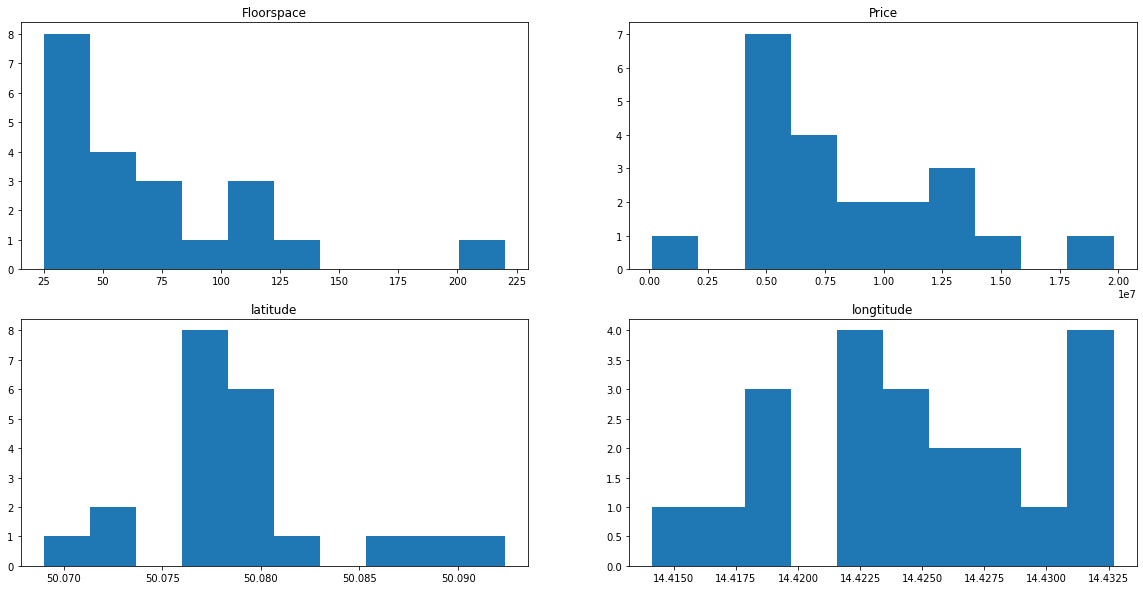

In [32]:
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.hist(num_NM_sale['Floorspace'])
plt.title('Floorspace')

plt.subplot(2,2,2)
plt.hist(num_NM_sale['Price'])
plt.title('Price')

plt.subplot(2,2,3)
plt.hist(num_NM_sale['lat'])
plt.title('latitude')

plt.subplot(2,2,4)
plt.hist(num_NM_sale['long'])
plt.title('longtitude')

plt.show()

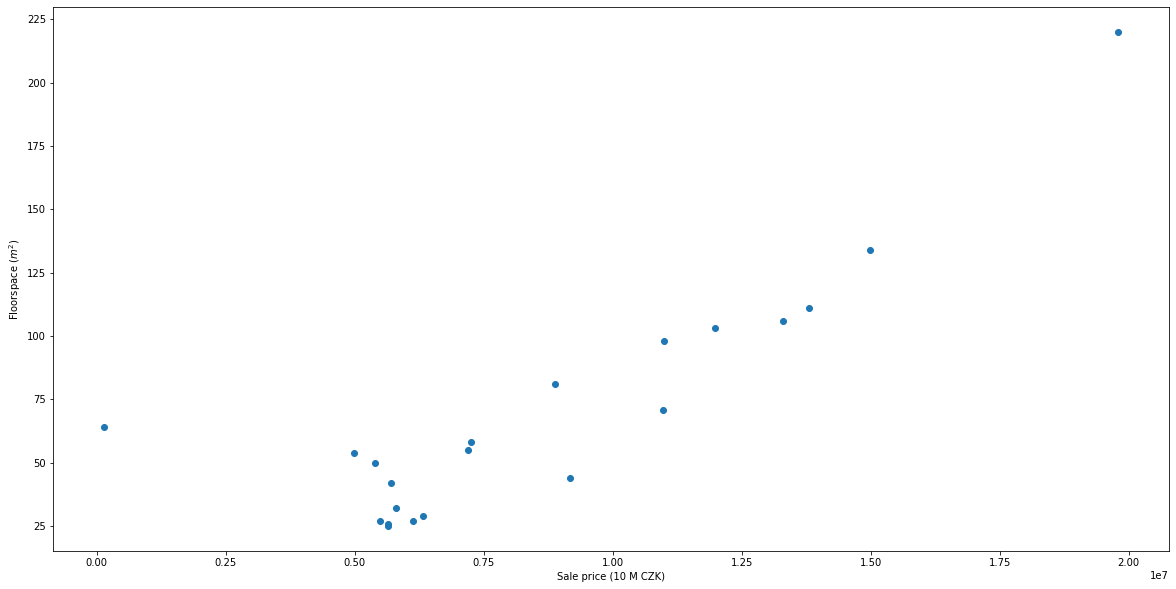

In [18]:
plt.figure(figsize = (20,10))
plt.scatter(num_NM_sale['Price'], num_NM_sale['Floorspace'])
plt.xlabel('Sale price (10 M CZK)')  # Add an x-label to the axes.
plt.ylabel('Floorspace ($m^2$)')  # Add a y-label to the axes.
plt.show()

# Categorial variables - Sale


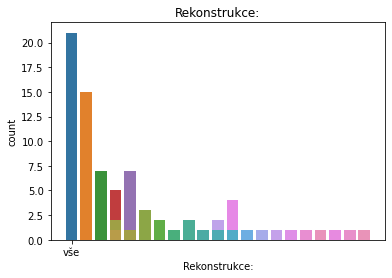

In [20]:
list(NM_sale.columns)
for i in list(NM_sale.columns):
    sns.countplot(NM_sale[i]).set_title(i)
    

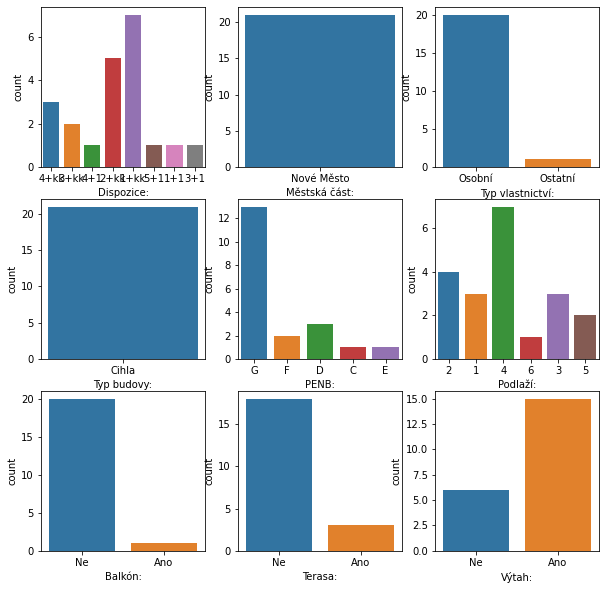

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))
sns.countplot(NM_sale['Dispozice:'], ax=axs[0,0] )#.set_title("Rooms")
sns.countplot(NM_sale['Městská část:'], ax=axs[0,1])#.set_title('District')
sns.countplot(NM_sale['Typ vlastnictví:'], ax=axs[0,2])#.set_title('Ownership')

sns.countplot(NM_sale['Typ budovy:'], ax=axs[1,0])#.set_title('Building type')
sns.countplot(NM_sale['PENB:'], ax=axs[1,1])#.set_title('Energy performance')
sns.countplot(NM_sale['Podlaží:'], ax=axs[1,2])#.set_title('Floor number')

sns.countplot(NM_sale['Balkón:'], ax=axs[2,0])#.set_title('Balcony')
sns.countplot(NM_sale['Terasa:'], ax=axs[2,1])#.set_title('Terace')
sns.countplot(NM_sale['Výtah:'], ax=axs[2,2])#.set_title('Elevator')

# sns.countplot(NM_sale['Garáž:'], ax=axs[3,0])#.set_title('Garage')



# RENT data

In [22]:
NM_rent['Plocha:'] = NM_rent['Plocha:'].str.extract('(\d+)').astype(float)
NM_rent["Cena:"] = NM_rent["Cena:"].str.replace('.', '').str.extract('(\d+)').astype(float)
NM_rent["lat"] = NM_rent["lat"].astype(float)
NM_rent["long"] = NM_rent["long"].astype(float)

num_col = ["Plocha:", "Cena:", "lat", "long"]
num_NM_rent = NM_rent[num_col]
num_NM_rent = num_NM_rent.rename(columns=num_col_dict)
num_NM_rent.head()

,Floorspace,Price,lat,long
Číslo inzerátu:,,,,
427251,145.0,30000.0,50.090822,14.429320
455020,31.0,15000.0,50.079695,14.422623
627055,117.0,22950.0,50.080329,14.419564
599979,28.0,12000.0,50.086305,14.429421
599687,30.0,12000.0,50.086305,14.429421


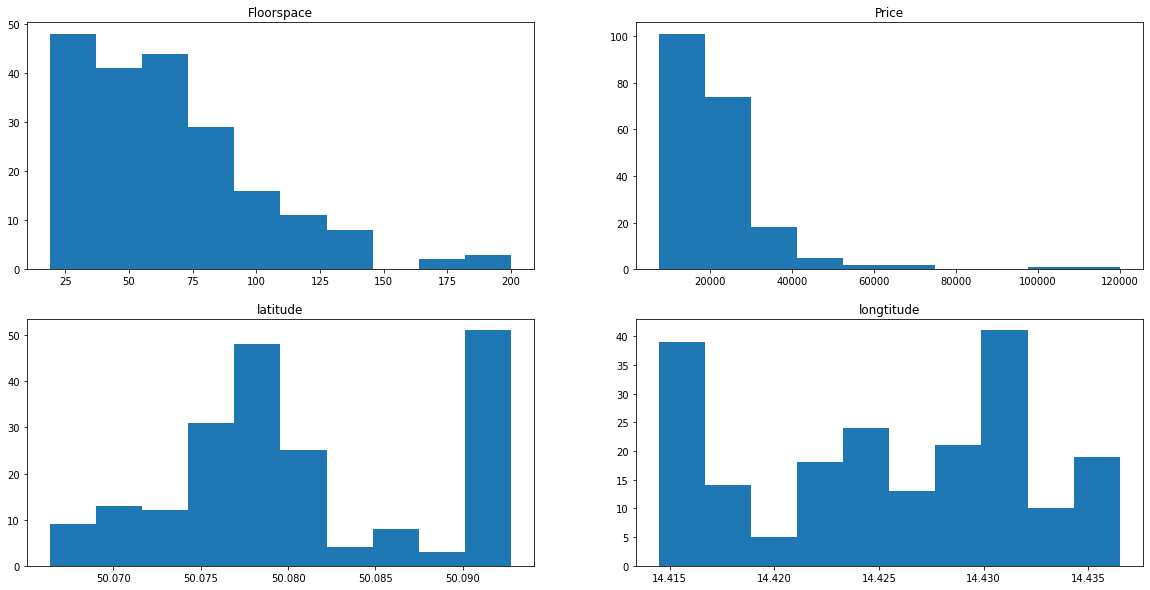

In [23]:
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.hist(num_NM_rent['Floorspace'])
plt.title('Floorspace')

plt.subplot(2,2,2)
plt.hist(num_NM_rent['Price'])
plt.title('Price')

plt.subplot(2,2,3)
plt.hist(num_NM_rent['lat'])
plt.title('latitude')

plt.subplot(2,2,4)
plt.hist(num_NM_rent['long'])
plt.title('longtitude')

plt.show()

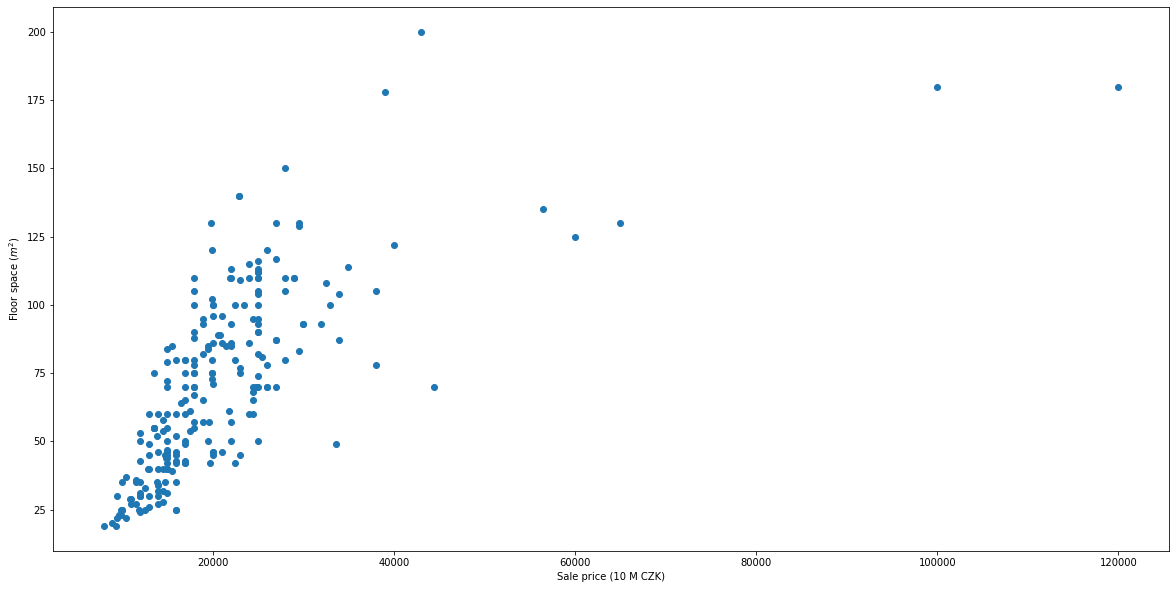

In [26]:
plt.figure(figsize = (20,10))
plt.scatter( num_NM_rent['Price'], num_NM_rent['Floorspace'])
plt.xlabel('Sale price (10 M CZK)')  # Add an x-label to the axes.
plt.ylabel('Floor space ($m^2$)')  # Add a y-label to the axes.
plt.show()

# Regression analysis
### OLS

In [28]:
y = num_NM_rent['Price']
X = num_NM_rent['Floorspace']
X = sm.add_constant(X)
NMr_ols_model = sm.OLS(y, X)
NMr_ols_results = NMr_ols_model.fit()
print(NMr_ols_results.summary())

C:\Users\janek\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     210.8
Date:                Thu, 21 May 2020   Prob (F-statistic):           2.09e-34
Time:                        11:24:13   Log-Likelihood:                -2446.9
No. Observations:                 234   AIC:                             4898.
Df Residuals:                     232   BIC:                             4905.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4175.1245   1272.859      3.280      0.0

### Quantile regression

In [29]:
NMr_qmod = smf.quantreg('Price ~ Floorspace', num_NM_rent)
NMr_qres = NMr_qmod.fit(q=.5)
print(NMr_qres.summary())

                         QuantReg Regression Results                          
Dep. Variable:                  Price   Pseudo R-squared:               0.3646
Model:                       QuantReg   Bandwidth:                       2725.
Method:                 Least Squares   Sparsity:                        8848.
Date:                Thu, 21 May 2020   No. Observations:                  234
Time:                        11:24:17   Df Residuals:                      232
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7257.1429    666.302     10.892      0.000    5944.367    8569.919
Floorspace   168.5714      8.501     19.828      0.000     151.821     185.321


In [33]:
quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = NMr_qmod.fit(q=q)
    return [q, res.params['Intercept'], res.params['Floorspace']] + \
            res.conf_int().loc['Floorspace'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])

ols = smf.ols('Price ~ Floorspace', num_NM_rent).fit()
ols_ci = ols.conf_int().loc['Floorspace'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['Floorspace'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

C:\Users\janek\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\janek\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


      q            a           b          lb          ub
0  0.05  6473.529411  108.823529   93.387093  124.259966
1  0.15  6653.246755  129.870130  114.383124  145.357136
2  0.25  6512.727271  147.272727  131.545764  162.999691
3  0.35  6771.086568  156.626486  141.158711  172.094260
4  0.45  7768.942357  153.849507  137.347118  170.351897
5  0.55  7833.333337  166.666667  149.001310  184.332024
6  0.65  8035.714285  178.571429  158.601891  198.540966
7  0.75  6696.428573  232.142857  207.035568  257.250146
8  0.85  5777.777781  277.777778  251.130873  304.424682
9  0.95     0.000006  500.000000  440.194819  559.805181
{'a': 4175.1244971875985, 'b': 235.77211400908504, 'lb': 203.77408695152258, 'ub': 267.7701410666475}


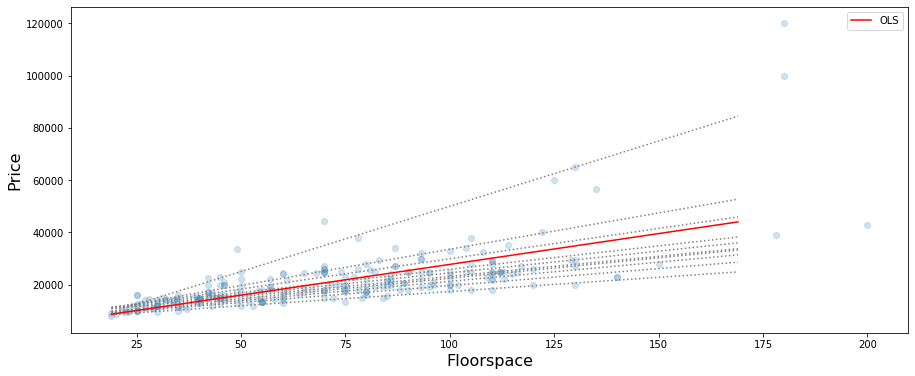

In [37]:
x = np.arange(num_NM_rent['Floorspace'].min(), num_NM_rent['Floorspace'].max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(15, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')

y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
# ax.scatter(num_NM_rent['Price'], num_NM_rent['Floorspace'], alpha=.2)
ax.scatter(num_NM_rent['Floorspace'],num_NM_rent['Price'], alpha = .2)
plt.xlabel('Sale price (10 M CZK)')  # Add an x-label to the axes.
plt.ylabel('Floor space ($m^2$)')  # Add a y-label to the axes.
# ax.set_xlim((10, 1000))
# ax.set_ylim((240, 2000))
legend = ax.legend()
ax.set_xlabel('Floorspace', fontsize=16)
ax.set_ylabel('Price', fontsize=16);

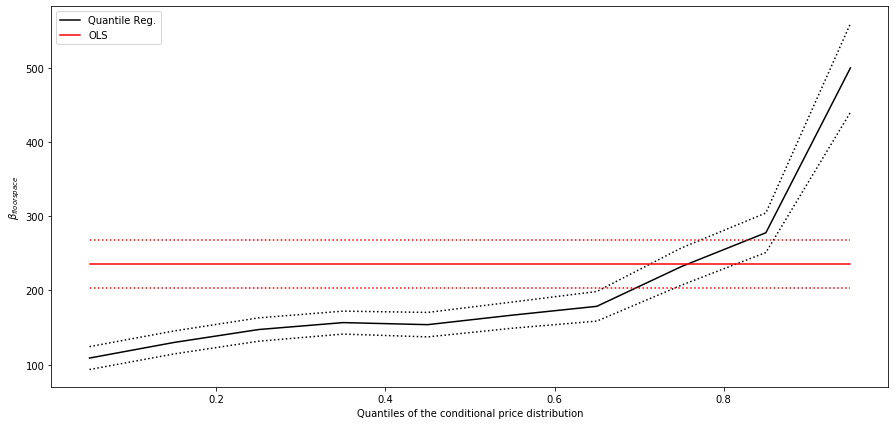

<Figure size 432x288 with 0 Axes>

In [36]:
plt.figure(figsize = (15,7))
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{floorspace}$')
plt.xlabel('Quantiles of the conditional price distribution')
plt.legend()
plt.show()
plt.savefig('Quantiles.png')